# Analysis in Appendix 7
In this notebook, we first see exclusion of fittest between two species su sampled from 10-species communities. Then, we quantify the similarity between the mean exclusion of the fittest and beta diverstiy in two- and ten-species communities.

To follow this analysis, you need to generate species parameter values using "./diversity_analysis/parm_generator.c" because we do not provide the row data of parameter values in each simulation.  Once you obtain species parameter values and calculate the beta diversity over the switching rate, you can replicate our analysis.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp #ode integration

In [5]:
# determine which species is the fittest in the deterministic scenario

def MeanField_sub10(i, j, beta, K):
    """
    i, j: int: indeces of species
    beta, K: float: matrices of parameter values 
    
    Return [k,l] means k is the fittest k = i or j
    """
    
    Tf=200 # time end
    init=np.concatenate([150*np.ones([10]), 10*np.ones([2])]) # initial condition
    sol = solve_ivp(ODE10, [0, Tf], y0=init, method='LSODA',
                    args=[beta[i-1, :], K[i-1,:], beta[j-1,:], K[j-1, :]]) # solving ode
    """
    # test of plot
    plt.plot(sol.t, sol.y[-2, :], label=str('species %d' %(i)), color='b')
    plt.plot(sol.t, sol.y[-1, :], label=str('species %d' %(j)), color='r')
    plt.legend(loc='best', fontsize=18)
    plt.show()
    """
    
    if sol.y[-2, -1]>pow(10, -3) and sol.y[-1, 0]<pow(10,-3):
        # species k outcompetes l
        return [i,j]
    elif sol.y[-2, -1]<pow(10, -3) and sol.y[-1, 0]>pow(10, -3):
        # species l outcompetes k
        return [j, i]
    elif sol.y[-2, -1]>pow(10, -3) and sol.y[-1, 0]>pow(10, -3):
        #coexistence  depending on population size
        if sol.y[-2, -1]>sol.y[-1,-1]:
            return [i,j]
        else:
            return [j,i]
    
    else:
        # both extinction    randomly chosen
        if np.random.rand()<0.5:
            return [i,j]
        else:
             return [j, i]
    
    
def ODE10(t, x, beta_k, K_k, beta_l, K_l):
    """
    Two species k & l + 5 resources +  5toxins' dynamics
    """
    alpha=0.1 # dilution rate
    inflow=125 # inflow of resource and toxin
    num_compound=np.size(beta_k)  
    dxdt=np.zeros(num_compound+2)
    for i in range(num_compound):
        dxdt[i]=alpha*(inflow-x[i]) -(abs(beta_k[i])*x[i]/(x[i]+K_k[i])*x[-2]) -\
        (abs(beta_l[i])*x[i]/(x[i]+K_l[i])*x[-1])
        dxdt[-2]+=beta_k[i]*x[i]/(x[i]+K_k[i])
        dxdt[-1]+=beta_l[i]*x[i]/(x[i]+K_l[i])
    dxdt[-2]=(dxdt[-2]-alpha)*x[-2]
    dxdt[-1]=(dxdt[-1]-alpha)*x[-1]
    return dxdt
    
    
    


In [47]:
# Here we obtain the parameter values of species
# Depending on where you put your species parameter values, change here
os.chdir('../diversity-switching/Half_RT_ver3/death0.1/species_number10/parameter1')
os.getcwd()

'/Users/shibasakishota/Desktop/diversity-switching/Half_RT_ver3/death0.1/Species_number10/parameter1/nu-5'

In [6]:
def ExclusionFittest(strong, weak, data):
    # return probability that weak outcompetes strong
    counter=0
    for i in range(np.size(data, 0)):
        if data[i, strong]<1 and data[i, weak]>=1:
            counter+=1
    return counter/np.size(data, 0)
    

def Analysis(index):
    beta=np.loadtxt(str('Prameter_beta_set%d.csv' %(index)), delimiter=',', skiprows=0)
    K=np.loadtxt(str('Prameter_K_set%d.csv' %(index)), delimiter=',', skiprows=0)
    nu_array=np.linspace(-5, 3, 9)
    excl=np.zeros([45, np.size(nu_array)])
    for v in range(np.size(nu_array)):
        nu=nu_array[v]
        os.chdir(str('nu%d' %(nu)))
        counter=0
        for i in range(1, 10):
            for j in range(i+1, 11):
                [k,l]=MeanField_sub10(i, j, beta, K) # mean field analysis decides which is the fittest
                #print([k,l])
                # analyze the exclusion of fittest in EFs and DN
                data=np.loadtxt(str('Dynamics_%dVS%d_nu%d_last.csv' %(i, j, nu)), 
                                   delimiter=',', skiprows=1)[:, 1:]
                
                if k<l:
                    # k is stronger species and has smallere index
                    excl[counter, v] = ExclusionFittest(0, 1, data)
                else:
                    excl[counter, v] = ExclusionFittest(1,0, data)
                counter+=1
        os.chdir('../')
    return excl
                
excl1=Analysis()  # this contains exclusion of fittest over the switching rate in each species pair     
#excl1
                                
                
                
            
            

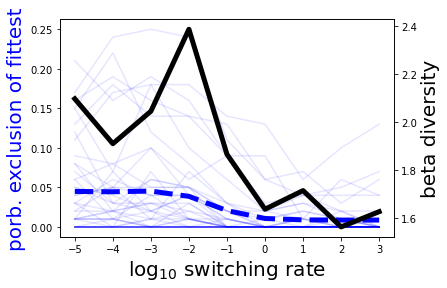

"                  \nplt.xlabel('$\\log_{10}$'+'switching rate',fontsize=20)\nplt.ylabel('porb. exclusion of fittest',fontsize=20)\nplt.xticks(fontsize=16, ticks=[-4, -2, 0, 2])\nplt.yticks(fontsize=16)\nplt.show()\n\n# beta diversity\n#\nplt.plot(np.linspace(-5, 3, 9), beta_div[0, :], color='k', linewidth=3)\nplt.xlabel('$\\log_{10}$'+'switching rate',fontsize=20)\nplt.ylabel('beta diversity',fontsize=20)\nplt.xticks(fontsize=16, ticks=[-4, -2, 0, 2])\nplt.yticks(fontsize=16)\nplt.show()\n"

In [101]:

#plot competitive exclusion in each pairs
fig = plt.figure()
ax1 = fig.add_subplot(111)
for i in range(np.size(excl1, 0)):
    ax1.plot(np.linspace(-5, 3, 9), excl1[i, :], color='b', alpha=0.1)
ax1.plot(np.linspace(-5, 3, 9), np.mean(excl1, 0), 
         linestyle='--', color='b', linewidth=5)
#plt.plot(np.linspace(-5, 3, 9), np.median(excl1, 0), color='k', linestyle='--', linewidth=3)
ax2=ax1.twinx()
ax2.plot(np.linspace(-5, 3, 9), beta_div[0, :], color='k', linewidth=5)
ax1.set_xlabel('$\log_{10}$'+' switching rate',fontsize=20)
ax1.set_ylabel('porb. exclusion of fittest',fontsize=20, color='b')
ax2.set_ylabel('beta diversity',fontsize=20)
plt.show()

"""                  
plt.xlabel('$\log_{10}$'+'switching rate',fontsize=20)
plt.ylabel('porb. exclusion of fittest',fontsize=20)
plt.xticks(fontsize=16, ticks=[-4, -2, 0, 2])
plt.yticks(fontsize=16)
plt.show()

# beta diversity
#
plt.plot(np.linspace(-5, 3, 9), beta_div[0, :], color='k', linewidth=3)
plt.xlabel('$\log_{10}$'+'switching rate',fontsize=20)
plt.ylabel('beta diversity',fontsize=20)
plt.xticks(fontsize=16, ticks=[-4, -2, 0, 2])
plt.yticks(fontsize=16)
plt.show()
"""    



In [90]:
os.chdir('../')
beta_div=np.loadtxt('BetaDiversity_death0.1_10species.csv', delimiter=',', skiprows=0)
os.chdir('./parameter1')


In [145]:
os.chdir('../../../')
os.getcwd()

'/Users/shibasakishota/Desktop/diversity-switching/Half_RT_ver3'

In [150]:
def main_subplot(parm_set=np.array([1])):
    """
    parm_set: 1dim array containning the indeces of parameter set to analyze
    """
    delta_array=np.array([0.1, 0.2, 0.4, 0.6, 1.0])
    nu_array=np.linspace(-5, 3, 9)
    for i in range(np.size(delta_array)):
        delta=delta_array[i]
        os.chdir(str('./death%.1f/Species_number10' %(delta)))
        # get beta diversity data
        beta_div=np.loadtxt(str('BetaDiversity_death%.1f_10species.csv'%(delta)),
                delimiter=',', skiprows=0)
        for j in range(np.size(parm_set)):
            index=parm_set[j]
            os.chdir(str('./parameter%d' %(index)))
            excl=Analysis(index) # data of exclusion of fittest in two-species pairs
            
            #Plot the results
            fig = plt.figure()
            ax1 = fig.add_subplot(111)
            for k in range(np.size(excl1, 0)): 
                ax1.plot(np.linspace(-5, 3, 9), excl[k, :], color='b', alpha=0.1)
                
            ax1.plot(np.linspace(-5, 3, 9), np.mean(excl, 0), 
                     linestyle='--', color='b', linewidth=5)
            #plt.plot(np.linspace(-5, 3, 9), np.median(excl1, 0), color='k', linestyle='--', linewidth=3)
            ax2=ax1.twinx()
            ax2.plot(np.linspace(-5, 3, 9), beta_div[index-1, :], color='k', linewidth=5)
            ax1.set_xlabel('$\log_{10}$'+' switching rate',fontsize=20)
            ax1.set_ylabel('porb. exclusion of fittest',fontsize=20, color='b')
            ax2.set_ylabel('beta diversity',fontsize=20)
            fname=str('Subsampling10_parameter%d_death%d.pdf' %(index, delta*10))
            plt.savefig(fname,bbox_inches='tight', pad_inches=0.05 )
            print([index, delta])
            plt.show()
                 
            os.chdir('../')
        os.chdir('../../')


                 
    

[1, 0.1]


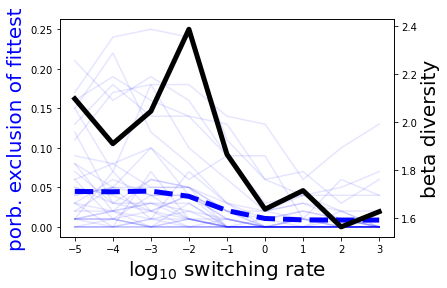

[1, 0.2]


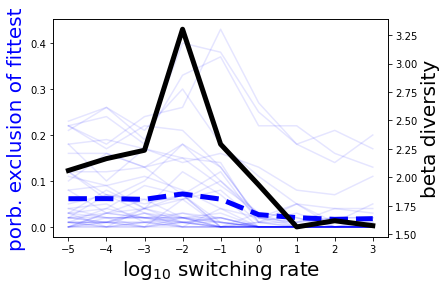

[1, 0.4]


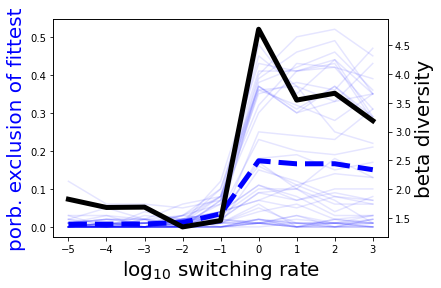

[1, 0.6]


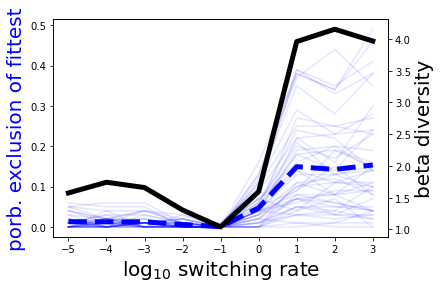

[1, 1.0]


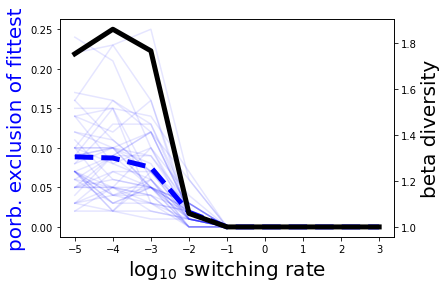

In [151]:
main_subplot(np.array([1]))

removing pairs where exclusion of fittest never happnes (i.e., deterministic results) may affects the results.

[1, 0.1]


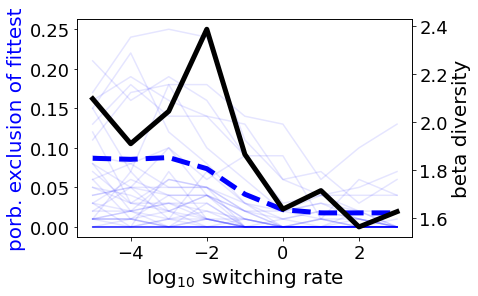

[2, 0.1]


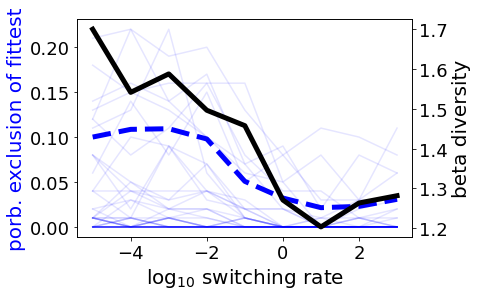

[3, 0.1]


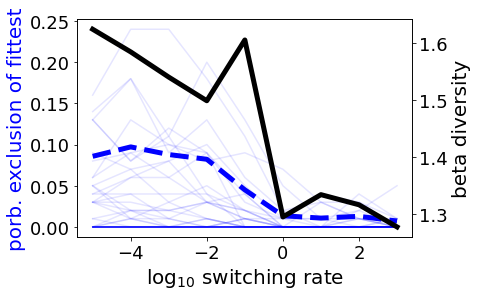

[4, 0.1]


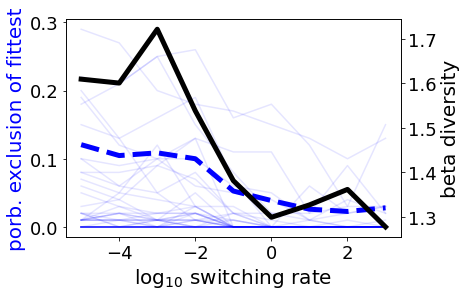

[5, 0.1]


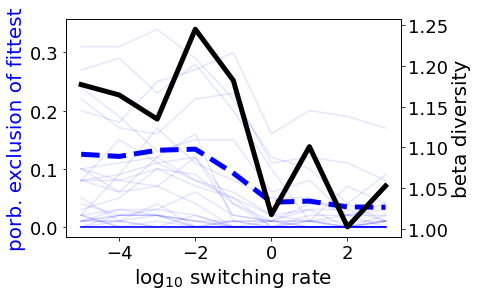

[6, 0.1]


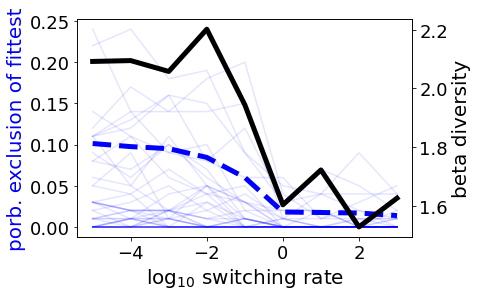

[1, 0.2]


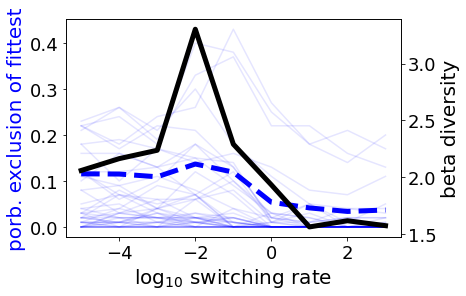

[2, 0.2]


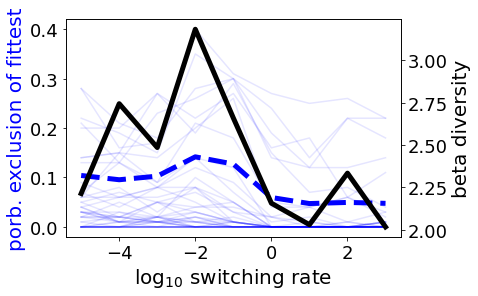

[3, 0.2]


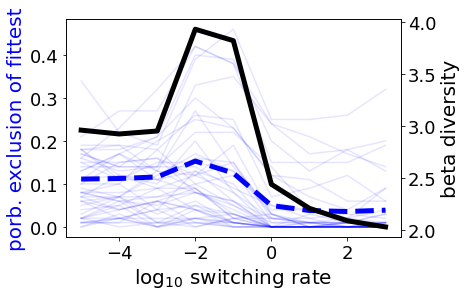

[4, 0.2]


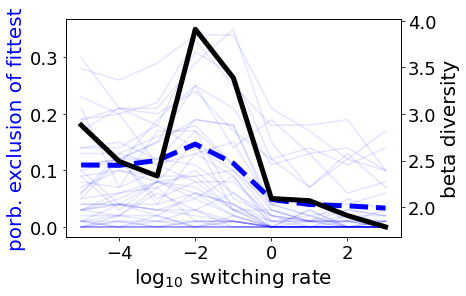

[5, 0.2]


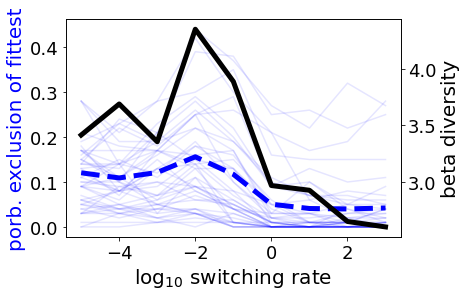

[6, 0.2]


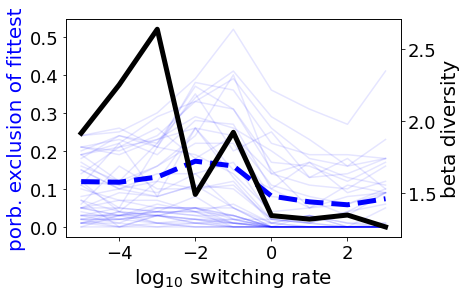

[1, 0.4]


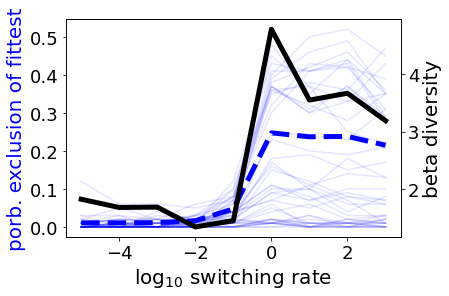

[2, 0.4]


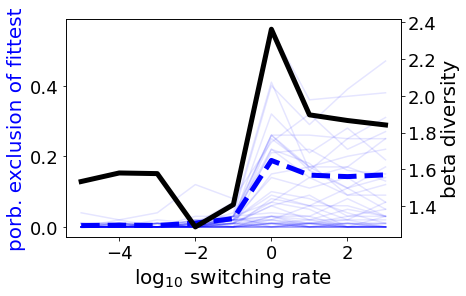

[3, 0.4]


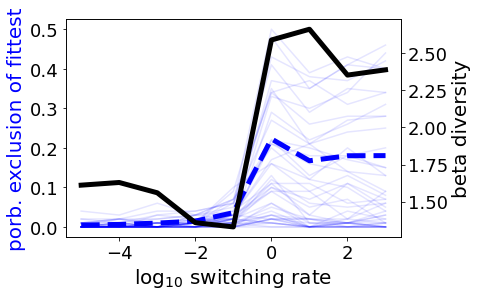

[4, 0.4]


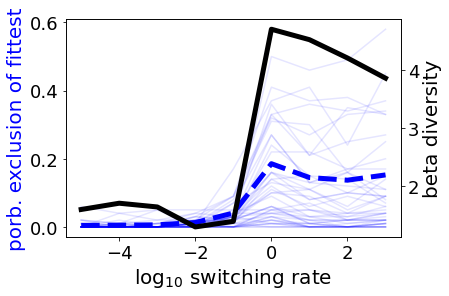

[5, 0.4]


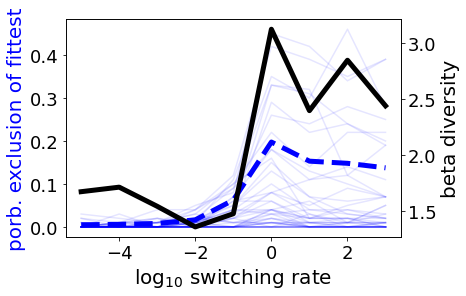

[6, 0.4]


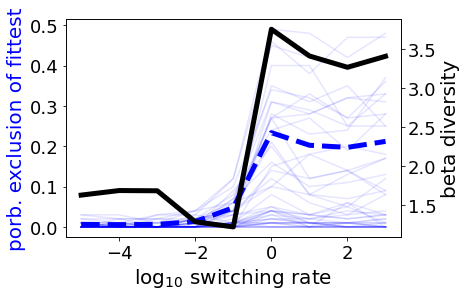

[1, 0.6]


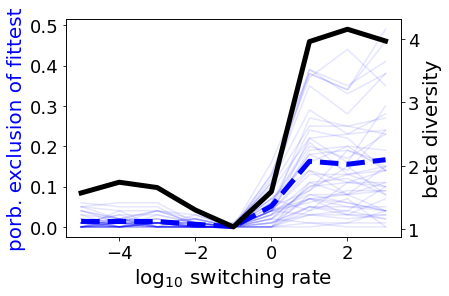

[2, 0.6]


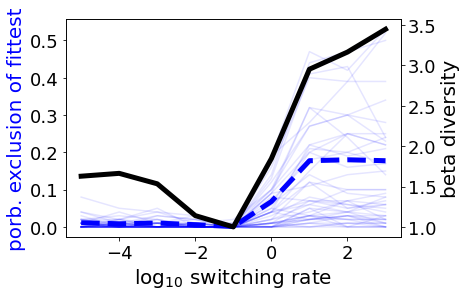

[3, 0.6]


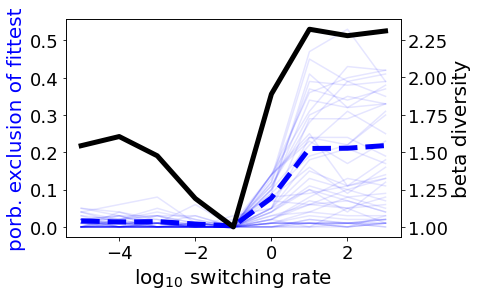

[4, 0.6]


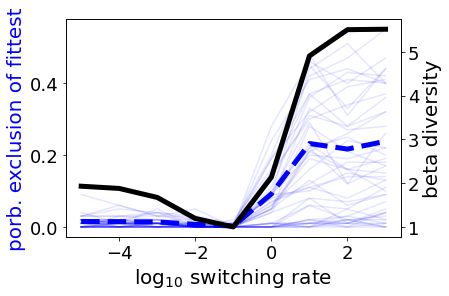

[5, 0.6]


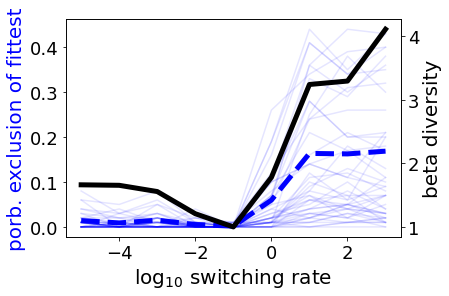

[6, 0.6]


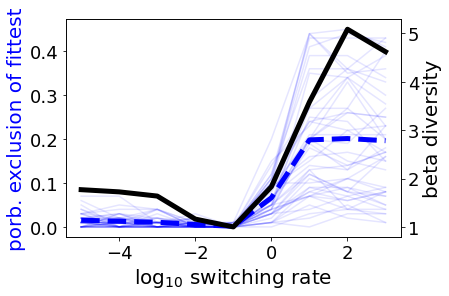

[1, 1.0]


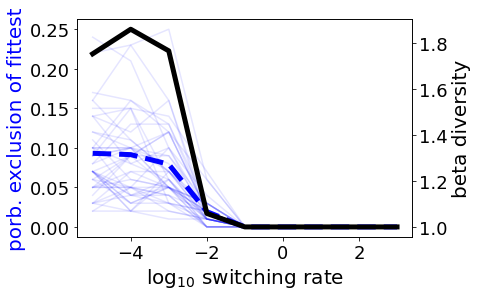

[2, 1.0]


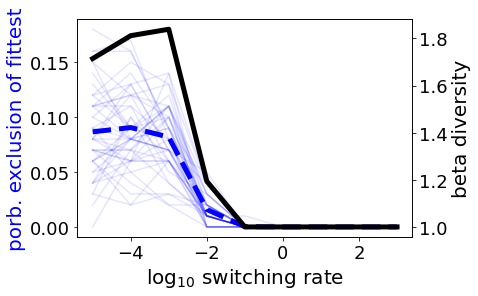

[3, 1.0]


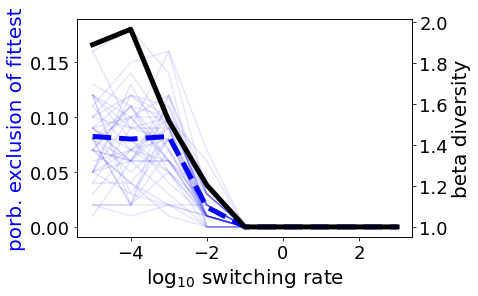

[4, 1.0]


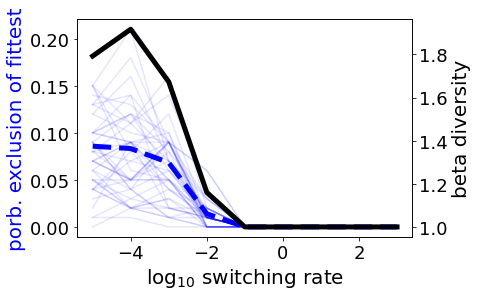

[5, 1.0]


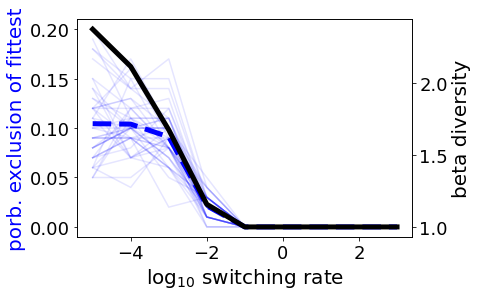

[6, 1.0]


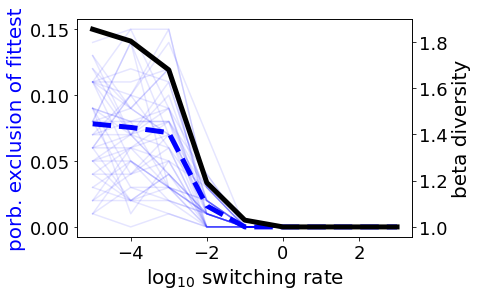

In [47]:
def Analysis(index):
    beta=np.loadtxt(str('Prameter_beta_set%d.csv' %(index)), delimiter=',', skiprows=0)
    K=np.loadtxt(str('Prameter_K_set%d.csv' %(index)), delimiter=',', skiprows=0)
    nu_array=np.linspace(-5, 3, 9)
    excl=np.zeros([45, np.size(nu_array)])
    for v in range(np.size(nu_array)):
        nu=nu_array[v]
        os.chdir(str('nu%d' %(nu)))
        counter=0
        for i in range(1, 10):
            for j in range(i+1, 11):
                [k,l]=MeanField_sub10(i, j, beta, K) # mean field analysis decides which is the fittest
                #print([k,l])
                # analyze the exclusion of fittest in EFs and DN
                data=np.loadtxt(str('Dynamics_%dVS%d_nu%d_last.csv' %(i, j, nu)), 
                                   delimiter=',', skiprows=1)[:, 1:]
                
                if k<l:
                    # k is stronger species and has smallere index
                    excl[counter, v] = ExclusionFittest(0, 1, data)
                else:
                    excl[counter, v] = ExclusionFittest(1,0, data)
                counter+=1
        os.chdir('../')
    delete_index=[]
    
    
    return excl
    

def main_subplot2(parm_set=np.array([1])):
    """
    parm_set: 1dim array containning the indeces of parameter set to analyze
    """
    delta_array=np.array([0.1, 0.2, 0.4, 0.6, 1.0])
    nu_array=np.linspace(-5, 3, 9)
    for i in range(np.size(delta_array)):
        delta=delta_array[i]
        os.chdir(str('./death%.1f/Species_number10' %(delta)))
        # get beta diversity data
        beta_div=np.loadtxt(str('BetaDiversity_death%.1f_10species.csv'%(delta)),
                delimiter=',', skiprows=0)
        for j in range(np.size(parm_set)):
            index=parm_set[j]
            os.chdir(str('./parameter%d' %(index)))
            excl=Analysis(index) # data of exclusion of fittest in two-species pairs
            
            #Plot the results
            fig = plt.figure()
            ax1 = fig.add_subplot(111)
            for k in range(np.size(excl, 0)): 
                ax1.plot(np.linspace(-5, 3, 9), excl[k, :], color='b', alpha=0.1)
            # remove uninformative pairs
            delete_index=[]
            for l in range(np.size(excl, 0)):
                #print(np.max(excl[l, :]))
                if np.max(excl[l, :])<0.05:
                    # remove this pair  as the results are almost deterministic     
                    delete_index.append(l)
            excl=np.delete(excl, delete_index, axis=0)
            ax1.plot(np.linspace(-5, 3, 9), np.mean(excl, 0), 
                     linestyle='--', color='b', linewidth=5)
            #plt.plot(np.linspace(-5, 3, 9), np.median(excl1, 0), color='k', linestyle='--', linewidth=3)
            ax2=ax1.twinx()
            ax2.plot(np.linspace(-5, 3, 9), beta_div[index-1, :], color='k', linewidth=5)
            ax1.set_xlabel('$\log_{10}$'+' switching rate',fontsize=20)
            ax1.set_ylabel('porb. exclusion of fittest',fontsize=20, color='b')
            ax1.tick_params(axis='x', labelsize=18)
            ax1.tick_params(axis='y', labelsize=18)
            ax2.tick_params(axis='y', labelsize=18)
            
            ax2.set_ylabel('beta diversity',fontsize=20)
            fname=str('Subsampling10_parameter%d_death%d.pdf' %(index, delta*10))
            plt.savefig(fname,bbox_inches='tight', pad_inches=0.0 )
            print([index, delta])
            plt.show()
                 
            os.chdir('../')
        os.chdir('../../')
main_subplot2(np.array([1,2,3,4,5,6]))

In [46]:
os.chdir('../../../../')
#os.chdir('./Half_RT_ver3')
os.getcwd()


'/Users/shibasakishota/Desktop/diversity-switching/Half_RT_ver3'

# Quantification of similarity between exclusion of fittest and beta diversity
To quantify the similarity of beta diversity and exclusio of the fittest, we calcualte Pearson's correlation of them.

First, to see whether calculating correlation is good or not, analyze two species scenarios.

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import pymc3 as pm
import seaborn as sns
from scipy.integrate import solve_ivp #ode integration
os.getcwd()


'/Users/shibasakishota/Desktop/diversity-switching/Half_RT_ver3'

In [3]:
# to move where we have two species data
os.chdir('../diversity-switching/Half_RT_ver3')
os.getcwd()

'/Users/shibasakishota/Desktop/diversity-switching/Half_RT_ver3'

In [26]:
def MeanField_2sp(beta, K):
    """
    i, j: int: indeces of species
    beta, K: float: matrices of parameter values 
    
    Return [k,l] means k is the fittest k = i or j
    """
    
    Tf=200 # time end
    init=np.concatenate([150*np.ones([2]), 10*np.ones([2])]) # initial condition
    sol = solve_ivp(ODE2, [0, Tf], y0=init, method='LSODA',
                    args=[beta[0, :], K[0,:], beta[1,:], K[1, :]]) # solving ode
    """
    # test of plot
    plt.plot(sol.t, sol.y[-2, :], label=str('species %d' %(i)), color='b')
    plt.plot(sol.t, sol.y[-1, :], label=str('species %d' %(j)), color='r')
    plt.legend(loc='best', fontsize=18)
    plt.show()
    """
    
    if sol.y[-2, -1]>pow(10, -3) and sol.y[-1, 0]<pow(10,-3):
        # species k outcompetes l
        return [1,2]
    elif sol.y[-2, -1]<pow(10, -3) and sol.y[-1, 0]>pow(10, -3):
        # species l outcompetes k
        return [2, 1]
    elif sol.y[-2, -1]>pow(10, -3) and sol.y[-1, 0]>pow(10, -3):
        #coexistence  depending on population size
        if sol.y[-2, -1]>sol.y[-1,-1]:
            return [1,2]
        else:
            return [2,1]
    
    else:
        # both extinction    randomly chosen
        if np.random.rand()<0.5:
            return [1,2]
        else:
             return [2, 1]
    
    
def ODE2(t, x, beta_k, K_k, beta_l, K_l):
    """
    Two species k & l + 5 resources +  5toxins' dynamics
    """
    alpha=0.1 # dilution rate
    inflow=125 # inflow of resource and toxin
    num_compound=np.size(beta_k)  
    dxdt=np.zeros(num_compound+2)
    for i in range(num_compound):
        dxdt[i]=alpha*(inflow-x[i]) -(abs(beta_k[i])*x[i]/(x[i]+K_k[i])*x[-2]) -\
        (abs(beta_l[i])*x[i]/(x[i]+K_l[i])*x[-1])
        dxdt[-2]+=beta_k[i]*x[i]/(x[i]+K_k[i])
        dxdt[-1]+=beta_l[i]*x[i]/(x[i]+K_l[i])
    dxdt[-2]=(dxdt[-2]-alpha)*x[-2]
    dxdt[-1]=(dxdt[-1]-alpha)*x[-1]
    return dxdt
    

def ExclusionFittest2(strong, weak, data):
    # return probability that weak outcompetes strong
    counter=0
    for i in range(np.size(data, 0)):
        if data[i, strong]<1 and data[i, weak]>=1:
            counter+=1
    return counter/np.size(data, 0)
    

def Analysis2(index):
    beta=np.loadtxt(str('Prameter_beta_set%d.csv' %(index)), delimiter=',', skiprows=0)
    K=np.loadtxt(str('Prameter_K_set%d.csv' %(index)), delimiter=',', skiprows=0)
    nu_array=np.linspace(-5, 3, 9)
    excl=np.zeros([np.size(nu_array)])
    for v in range(np.size(nu_array)):
        nu=nu_array[v]
        [k,l]=MeanField_2sp(beta, K) # mean field analysis decides which is the fittest
        #print([k,l]               
        # analyze the exclusion of fittest in EFs and DN
        data=np.loadtxt(str('Dynamics_nu%d_last.csv' %(nu)), 
                                   delimiter=',', skiprows=1)[:, 3:5]
                
        if k<l:
            # k is stronger species and has smallere inde
            excl[v] = ExclusionFittest2(0, 1, data)
        else:
            excl[v] = ExclusionFittest2(1,0, data)
    return excl

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


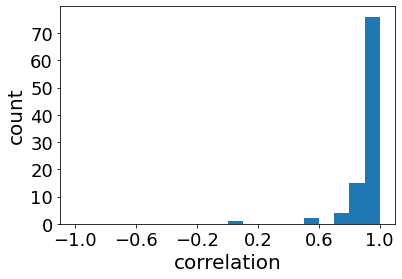

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


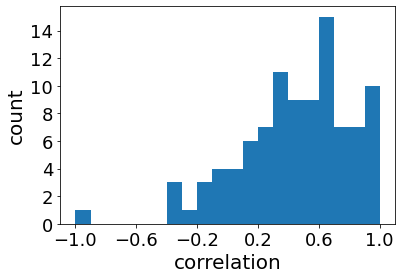

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


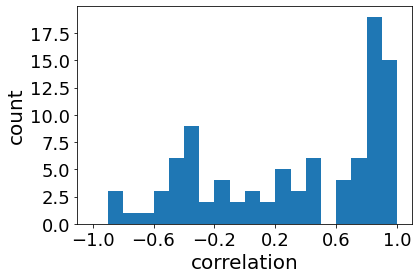

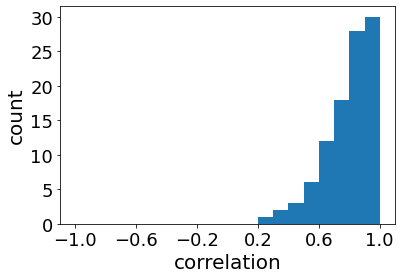

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


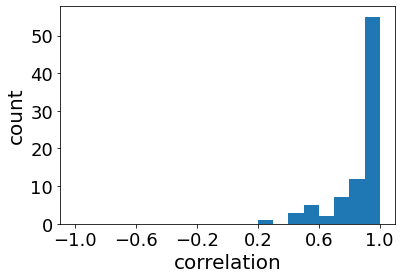

In [167]:
d_array=np.array([0.1, 0.2, 0.4, 0.6, 1.0])
# histgram of the correlations in two-species communities at each mean toxin sensitivity 
for i in range(np.size(d_array)):
    os.chdir(str('./death%.1f/species_number2' %(d_array[i])))
    #get beta diversity
    beta_div=np.loadtxt(str('BetaDiversity_death%.1f_2species.csv' %(d_array[i])),
                       delimiter=',', skiprows=0)
    # calculate the exclusion of fittest
    excl=np.zeros([np.size(beta_div,1)])
    corr=np.zeros([100]) # pearson's corr
    for j in range(100):
        os.chdir(str('./parameter%d' %(j+1)))
        excl=Analysis2(j+1)
        corr[j], p = sp.stats.pearsonr(excl, beta_div[j, :])
        os.chdir('../')
        
    # plot scatter plot and save result
    np.savetxt('Corr_BetaDiv_ExclFittest.csv', corr, delimiter=',')
    plt.hist(corr, bins=20, range=(-1.0, 1.0))
    plt.xlabel('correlation', fontsize=20)
    plt.ylabel('count', fontsize=20)
    #plt.title(str('mean toxin sensitivity %.1f' %(d_array[i])), fontsize=20)
    plt.xticks([-1.0, -0.6, -0.2, 0.2, 0.6,1.0], fontsize=18)
    plt.yticks(fontsize=18)
    fname=str('Distribution_Corr_Beta_Excl_Toxin%.1f.pdf' %(d_array[i]))
    plt.savefig(fname,bbox_inches='tight', pad_inches=0.05)
    plt.show()
    os.chdir('../../')
        

Except for $\bar{\delta}=0.4$, we tend to obrain large correlations. Therefore, quantification with correlation is reasonable.


Next, we contnue this analysis in ten-species communities. As we have 45 species pairs, we need to consider how many pairs we should observe to get large correlations. Note we do not test all posssible combination of pairs.

In [168]:
def MeanField_sub10(i, j, beta, K):
    """
    i, j: int: indeces of species
    beta, K: float: matrices of parameter values 
    
    Return [k,l] means k is the fittest k = i or j
    """
    
    Tf=200 # time end
    init=np.concatenate([150*np.ones([10]), 10*np.ones([2])]) # initial condition
    sol = solve_ivp(ODE10, [0, Tf], y0=init, method='LSODA',
                    args=[beta[i-1, :], K[i-1,:], beta[j-1,:], K[j-1, :]]) # solving ode
    """
    # test of plot
    plt.plot(sol.t, sol.y[-2, :], label=str('species %d' %(i)), color='b')
    plt.plot(sol.t, sol.y[-1, :], label=str('species %d' %(j)), color='r')
    plt.legend(loc='best', fontsize=18)
    plt.show()
    """
    
    if sol.y[-2, -1]>pow(10, -3) and sol.y[-1, 0]<pow(10,-3):
        # species k outcompetes l
        return [i,j]
    elif sol.y[-2, -1]<pow(10, -3) and sol.y[-1, 0]>pow(10, -3):
        # species l outcompetes k
        return [j, i]
    elif sol.y[-2, -1]>pow(10, -3) and sol.y[-1, 0]>pow(10, -3):
        #coexistence  depending on population size
        if sol.y[-2, -1]>sol.y[-1,-1]:
            return [i,j]
        else:
            return [j,i]
    
    else:
        # both extinction    randomly chosen
        if np.random.rand()<0.5:
            return [i,j]
        else:
             return [j, i]
    
    
def ODE10(t, x, beta_k, K_k, beta_l, K_l):
    """
    Two species k & l + 5 resources +  5toxins' dynamics
    """
    alpha=0.1 # dilution rate
    inflow=125 # inflow of resource and toxin
    num_compound=np.size(beta_k)  
    dxdt=np.zeros(num_compound+2)
    for i in range(num_compound):
        dxdt[i]=alpha*(inflow-x[i]) -(abs(beta_k[i])*x[i]/(x[i]+K_k[i])*x[-2]) -\
        (abs(beta_l[i])*x[i]/(x[i]+K_l[i])*x[-1])
        dxdt[-2]+=beta_k[i]*x[i]/(x[i]+K_k[i])
        dxdt[-1]+=beta_l[i]*x[i]/(x[i]+K_l[i])
    dxdt[-2]=(dxdt[-2]-alpha)*x[-2]
    dxdt[-1]=(dxdt[-1]-alpha)*x[-1]
    return dxdt



In [77]:

    

def preparetion():
    """
    Before starting analysis, we will find the fittest species in each pair
    """
    d_array=np.array([0.1, 0.2, 0.4, 0.6, 1.0]) # mean toxin sensitivity
    sample_set=np.array([1,2,3,4,5,6]) # which parameter set we use
    for i in range(np.size(d_array)):
        d=d_array[i]
        path=str('./death%.1f/species_number10' %(d))
        os.chdir(path)
        for j in range(np.size(sample_set)):
            index=sample_set[j]
            ans=np.zeros([45, 2])
            counter=0
            os.chdir(str('./parameter%d' %(index)))
            beta=np.loadtxt(str('Prameter_beta_set%d.csv' %(index)), delimiter=',', skiprows=0)
            K=np.loadtxt(str('Prameter_K_set%d.csv' %(index)), delimiter=',', skiprows=0)
            for k in range(1, 10):
                for l in range(k+1, 11):
                    [strong,weak]=MeanField_sub10(k, l, beta, K) # mean field analysis decides which is the fittest
                    ans[counter,0]=strong
                    ans[counter,1]=weak
                    counter+=1
            np.savetxt('MeanFieldCompetition.csv', ans,
                      delimiter=',', header='Strong, Weak', fmt='%d, %d')
            os.chdir('../')
        os.chdir('../../')

In [78]:
 preparetion()

In [177]:
# now we do not have to calcualte which species is the fittest

def Exclusion(strong, weak):
    nu_array=np.linspace(-5,3, 9)
    ans=np.zeros([9]) # exclusion of fittest over the switching rate
    for v in range(np.size(nu_array)):
        nu=nu_array[v]
        os.chdir(str('./nu%d' %(nu)))
        if strong>weak:
            data=np.loadtxt(str('Dynamics_%dVS%d_nu%d_last.csv' %(weak, strong, nu)), 
                                   delimiter=',', skiprows=1)[:, 1:]
            ans[v]=ExclusionFittest(1, 0, data)
        else:
            data=np.loadtxt(str('Dynamics_%dVS%d_nu%d_last.csv' %(strong,weak, nu)), 
                                   delimiter=',', skiprows=1)[:, 1:]
            ans[v]=ExclusionFittest(0, 1, data)
        
        os.chdir('../')
    return ans
    
def ExclusionFittest(strong, weak, data):
    # return probability that weak outcompetes strong
    counter=0
    for i in range(np.size(data, 0)):
        if data[i, strong]<1 and data[i, weak]>=1:
            counter+=1
    return counter/np.size(data, 0)

def main(num_pairs=1):
    """
    In this scenario, we need to detemine how many species pair we obtain,
    which is given by num_pairs.
    Then, we calcualte the correlation between mean prob of exclusion of the fittest 
    and beta diversity in the ten-species community.
    If 1<num_pairs<45, we do not analyze all possible num_pairs species pairs; instead we sample
    300 num_pairs pairs in each community.
    """
    
    sample_set=np.array([1,2,3,4,5,6])
    d_array=np.array([0.1, 0.2, 0.4, 0.6, 1.0
                     ])
    for i in range(np.size(d_array)):
        corr=[]
        d=d_array[i]
        path=str('./death%.1f/species_number10' %(d))
        os.chdir(path)
        # get beta diversity
        beta_div=np.loadtxt(str('BetaDiversity_death%.1f_10species.csv'%(d)),
                delimiter=',', skiprows=0)
        for j in range(np.size(sample_set)):
            index=sample_set[j]
            os.chdir(str('./parameter%d' %(index)))
            MeanField=np.loadtxt('MeanFieldCompetition.csv',
                                delimiter=',', skiprows=1, dtype=np.int)
            if num_pairs==1:
                for k in range(np.size(MeanField, 0)):
                    excl=np.zeros([9])
                    strong, weak = MeanField[k, :]
                    excl=Exclusion(strong, weak)
                    r, p= sp.stats.pearsonr(beta_div[index-1], excl)
                    corr.append(r)
            elif num_pairs==45:
                # using all
                excl=np.zeros([num_pairs, 9])
                for k in range(np.size(MeanField, 0)):
                    strong, weak = MeanField[k, :]
                    excl[k, :]=Exclusion(strong, weak)
                mean_excl=np.nanmean(excl, 0)
                r, p= sp.stats.pearsonr(beta_div[index-1], mean_excl)
                corr.append(r)
                
            else:
                # we sample certain number of pairs
                for trial in range(300):
                    excl=np.zeros([num_pairs, 9])
                    sample_k=np.random.randint(low=0, high=np.size(MeanField, 0), 
                                               size=num_pairs)
                    for k in range(np.size(sample_k)):
                        strong, weak = MeanField[sample_k[k], :]
                        excl[k, :]=Exclusion(strong, weak)
                    mean_excl=np.nanmean(excl, 0)
                    r, p= sp.stats.pearsonr(beta_div[index-1], mean_excl)
                    corr.append(r)
                        
                    
            os.chdir('../')
        plt.hist(corr, bins=20, range=(-1.0, 1.0), density=False, cumulative=False)
        plt.xlabel('correlation', fontsize=20)
        plt.ylabel('count', fontsize=20)
        #plt.title(str('mean toxin sensitivity %.1f' %(d_array[i])), fontsize=20)
        plt.xticks([-1.0, -0.6, -0.2, 0.2, 0.6,1.0], fontsize=18)
        plt.yticks(fontsize=18)
        fname=str('Distribution_Corr_Beta_Excl_Toxin%.1f_%dpair.pdf' 
                      %(d_array[i], num_pairs))
        plt.savefig(fname,bbox_inches='tight', pad_inches=0.05)
        plt.show()
            
        os.chdir('../../')
    
                    
        

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


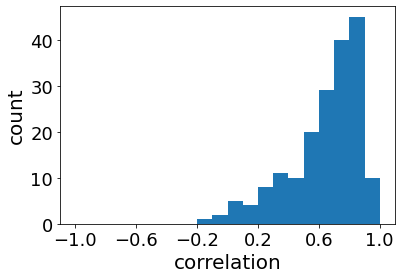

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


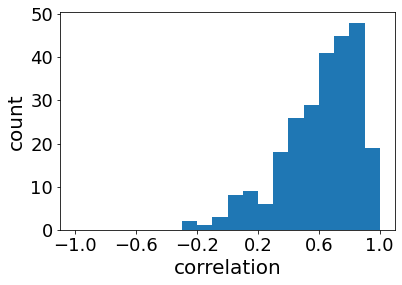

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


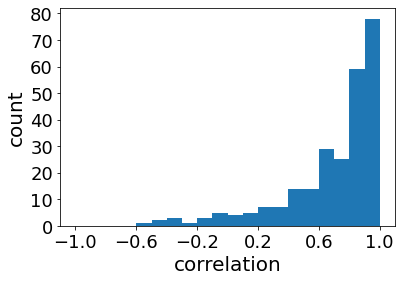

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


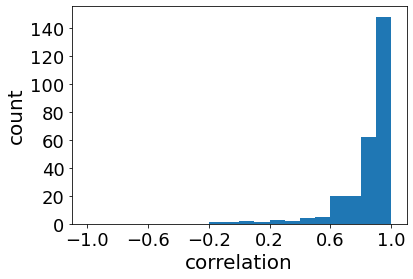

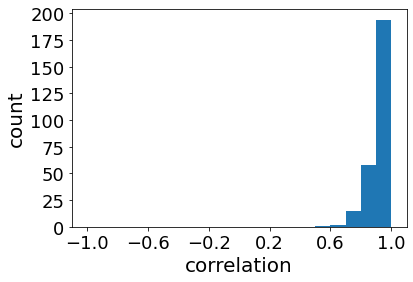

In [165]:
cor=main(num_pairs=1)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


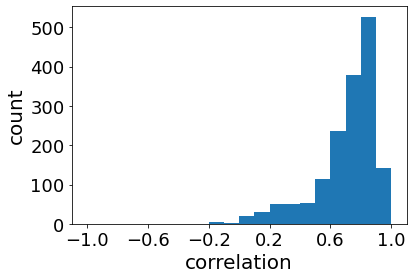

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


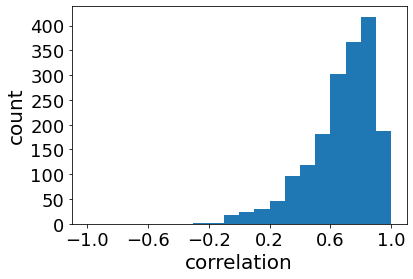

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


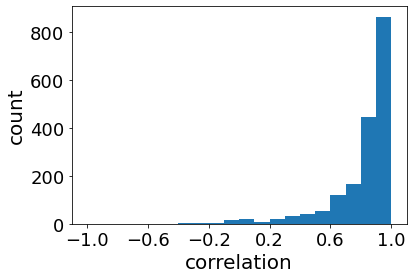

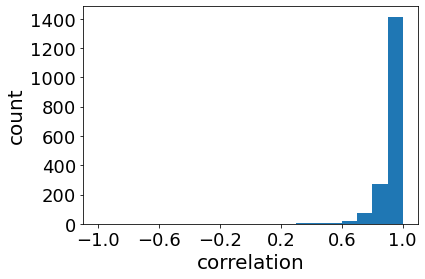

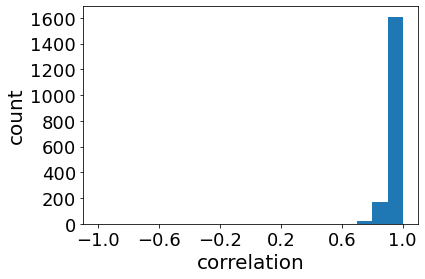

In [181]:
main(num_pairs=2)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


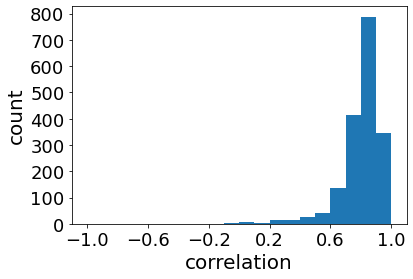

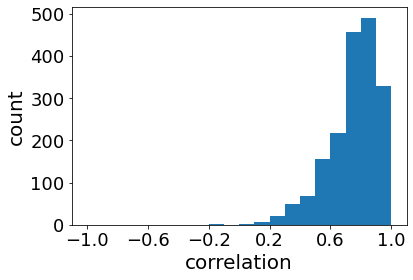

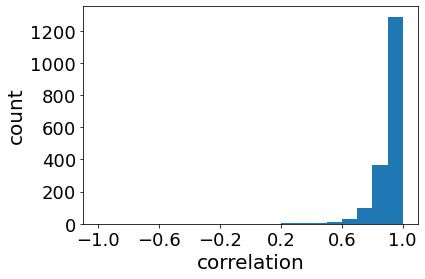

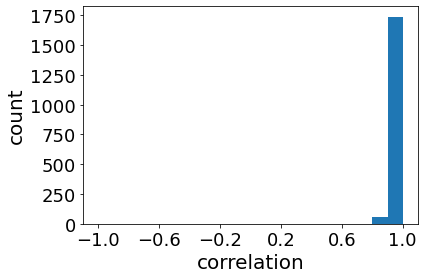

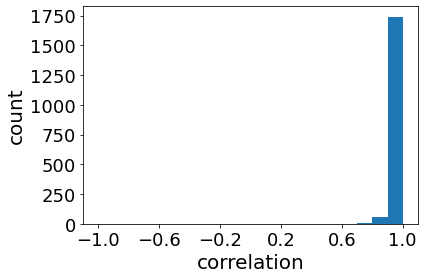

In [182]:
main(num_pairs=5)


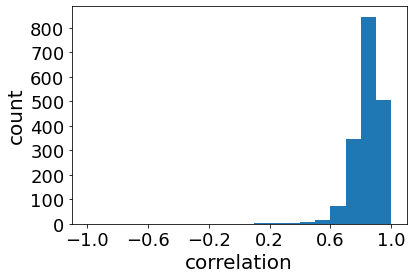

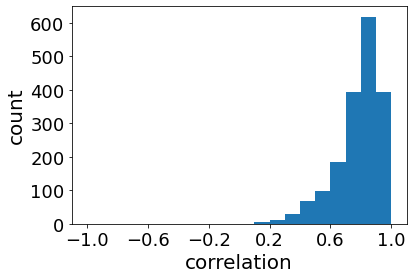

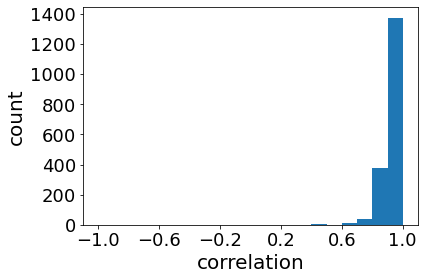

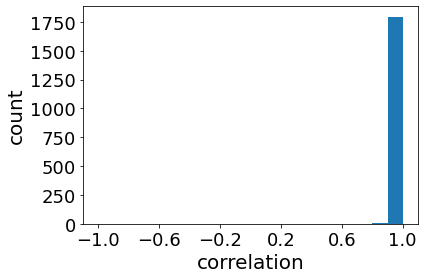

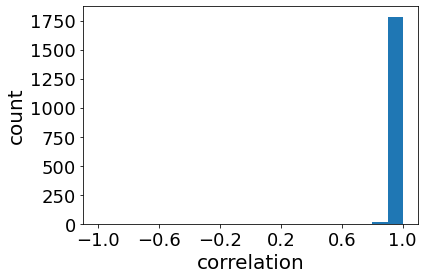

In [183]:
main(num_pairs=9)

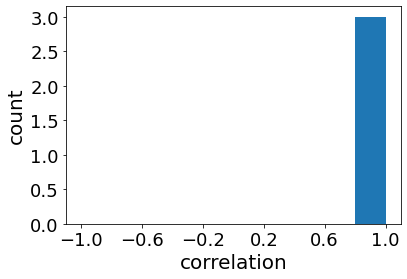

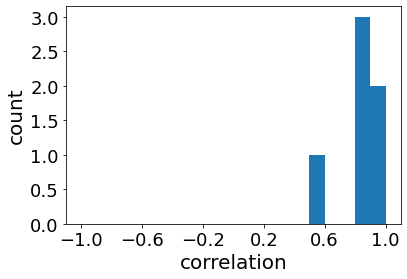

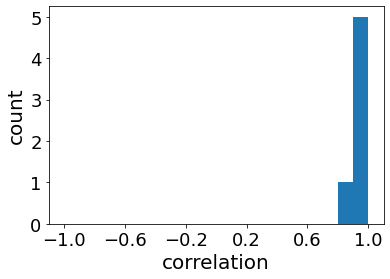

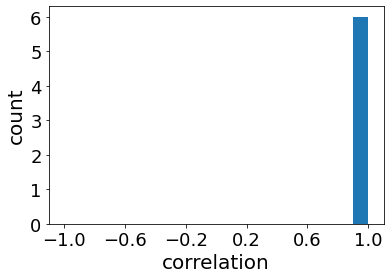

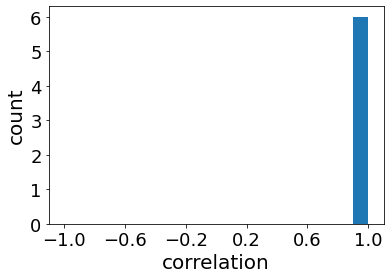

In [180]:
main(num_pairs=45)